# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset

In [2]:
# Define the transform to normalize the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset_path = '/kaggle/input/satellite-image-classification/data'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader

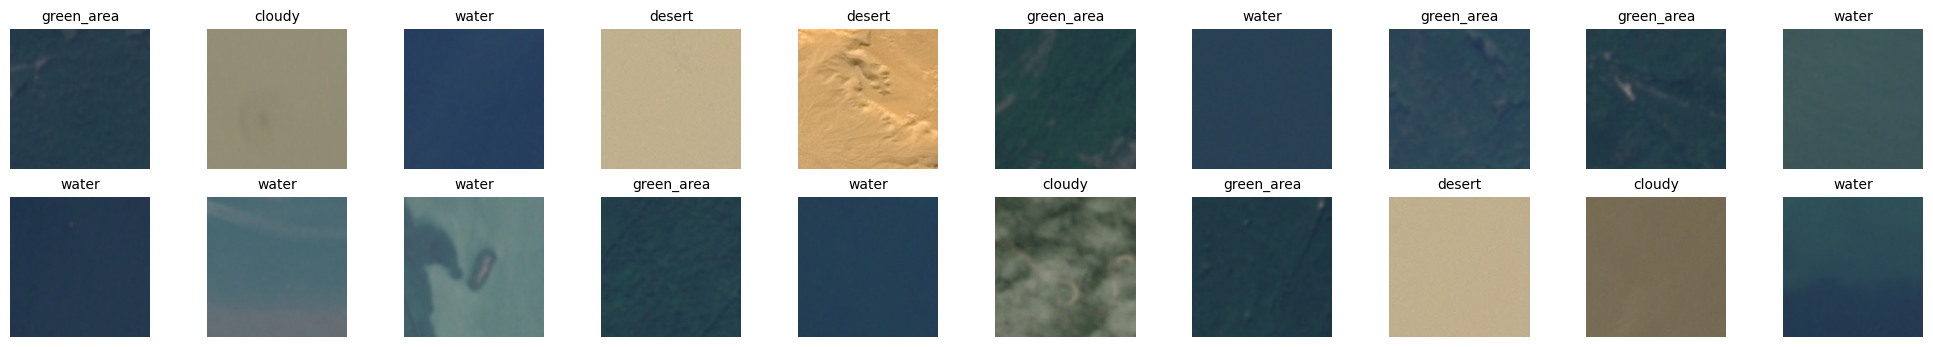

In [3]:
def plot_img(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1)
    plot_img(images[idx], title=dataset.classes[labels[idx]])

plt.show()


# Model Load

In [4]:
model = models.efficientnet_b0(pretrained=True)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 151MB/s]


# Remove the last layer

In [5]:
# Access the last layer of the classifier
last_layer = model.classifier[-1]

# Get the number of input features for the last layer
num_features = last_layer.in_features

# Define a new linear layer with the appropriate number of output features
num_classes = len(dataset.classes)

# Replace the last layer of the classifier with the new linear layer
model.classifier[-1] = nn.Linear(num_features, num_classes).to(device)


# Define loss function and optimizer

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Num of Epochs

In [7]:
num_epochs = 5

# Training and Testing 

In [8]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Training Loss: {train_losses[-1]}")

    # Testing loop
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_losses.append(test_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Test Loss: {test_losses[-1]}, Accuracy: {100 * correct / total}%")

Epoch 1, Training Loss: 0.447757898915744
Epoch 1, Test Loss: 0.11708269082009792, Accuracy: 97.95918367346938%
Epoch 2, Training Loss: 0.09048721089906303
Epoch 2, Test Loss: 0.06429707450378272, Accuracy: 98.58030168589175%
Epoch 3, Training Loss: 0.06145671465110483
Epoch 3, Test Loss: 0.04836011667632394, Accuracy: 98.66903283052352%
Epoch 4, Training Loss: 0.04698543524508305
Epoch 4, Test Loss: 0.03861251298803836, Accuracy: 99.29015084294588%
Epoch 5, Training Loss: 0.02753850131738165
Epoch 5, Test Loss: 0.036660660200545356, Accuracy: 99.02395740905058%


# Plot the Training and Testing loss Vs Epochs

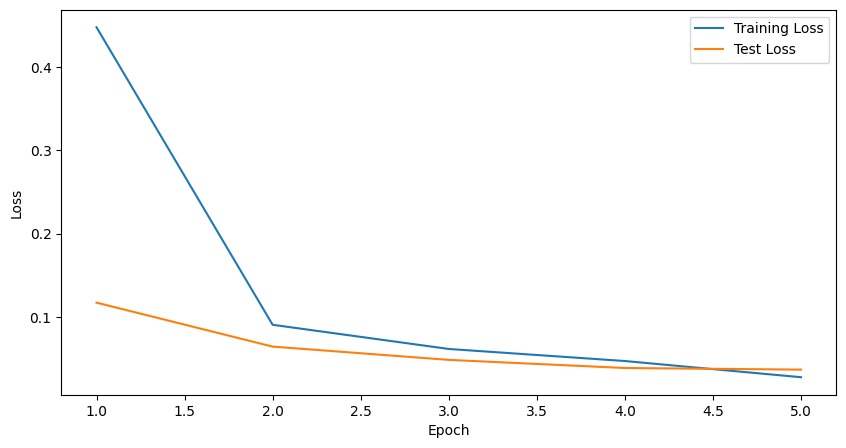

In [9]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ***Finetune only the last layer and test it***

# Saliency Map

In [10]:
def generate_saliency_map(image, model):
    model.train()  # Set model to training mode
    image = image.unsqueeze(0).to(device)
    image.requires_grad = True

    output = model(image)
    _, predicted_class = torch.max(output, 1)

    model.zero_grad()
    output[:, predicted_class].backward()  # Backpropagate from the predicted class score

    gradients = image.grad
    saliency_map = gradients.abs().max(dim=1)[0]

    return saliency_map.squeeze()


# Freeze all the layers except the last one 

In [11]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model.classifier.parameters():
    param.requires_grad = True

# Train and Test 

In [12]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Training Loss: {train_losses[-1]}")

    # Testing loop
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_losses.append(test_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Test Loss: {test_losses[-1]}, Accuracy: {100 * correct / total}%")

Epoch 1, Training Loss: 0.037097142109356766
Epoch 1, Test Loss: 0.03713755973149091, Accuracy: 99.02395740905058%
Epoch 2, Training Loss: 0.02956289977845835
Epoch 2, Test Loss: 0.03375443538728481, Accuracy: 98.75776397515529%
Epoch 3, Training Loss: 0.030290288607926763
Epoch 3, Test Loss: 0.03127359312364004, Accuracy: 99.37888198757764%
Epoch 4, Training Loss: 0.027858841483124553
Epoch 4, Test Loss: 0.030109184018025797, Accuracy: 99.11268855368235%
Epoch 5, Training Loss: 0.022453763435515476
Epoch 5, Test Loss: 0.03087813764836432, Accuracy: 99.11268855368235%


# Evaluate

In [14]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    confusion = confusion_matrix(all_targets, all_predictions)

    return accuracy, precision, recall, f1, confusion

# Call the evaluate function
accuracy_1, precision_1, recall_1, f1_1, confusion_1 = evaluate(model, test_loader)

print("Accuracy:", accuracy_1)
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1-score:", f1_1)
print("Confusion Matrix:")
print(confusion_1)

Accuracy: 0.997338065661047
Precision: 0.9973410522003088
Recall: 0.997338065661047
F1-score: 0.9973381019063439
Confusion Matrix:
[[283   0   0   0]
 [  0 238   0   0]
 [  0   0 304   2]
 [  0   0   1 299]]


# Plot the train and test Vs Epochs

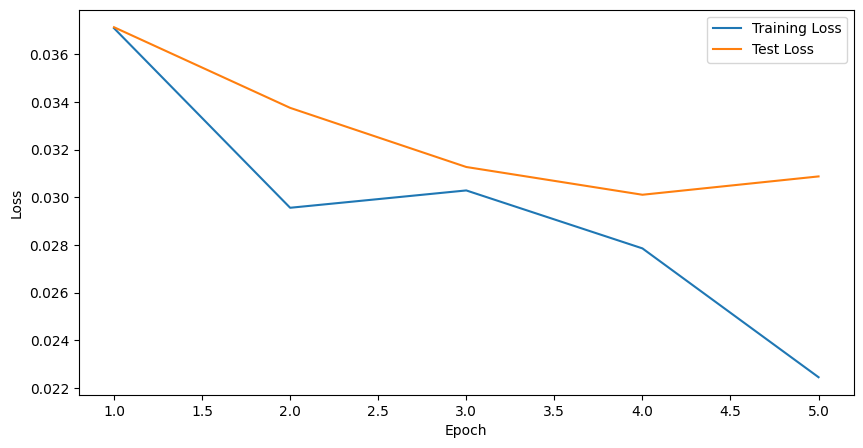

In [15]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Saliency Map

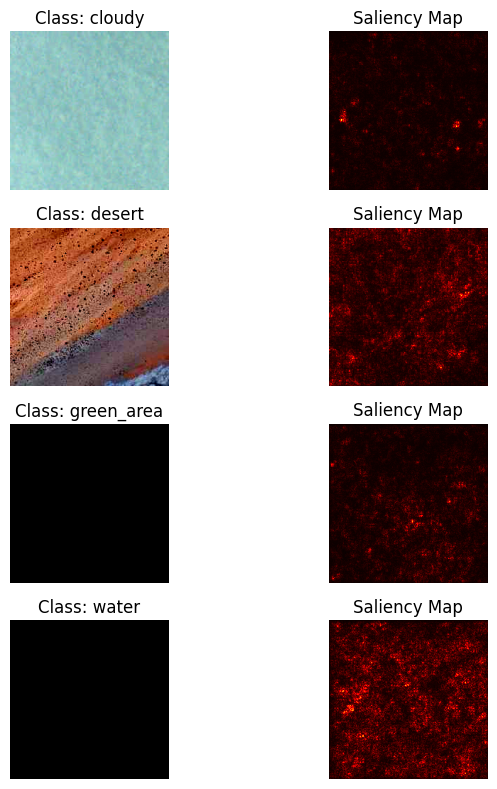

In [16]:
# Get some sample images from the test dataset
sample_images = []
sample_labels = []

# Collect at most one image per class
for class_index in range(len(dataset.classes)):
    class_images = torch.stack([image for image, label in test_dataset if label == class_index])
    if len(class_images) > 0:
        sample_images.append(class_images[0])
        sample_labels.append(class_index)

sample_images = torch.stack(sample_images)
sample_labels = torch.tensor(sample_labels)

# Generate and visualize saliency maps for each class
class_names = dataset.classes
num_classes = len(class_names)
fig, axes = plt.subplots(num_classes, 2, figsize=(8, 2 * num_classes))
for i in range(num_classes):
    class_index = i
    sample_image = sample_images[sample_labels == class_index][0]
    saliency_map = generate_saliency_map(sample_image, model)
    
    axes[i, 0].imshow(sample_image.permute(1, 2, 0).cpu().numpy())
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Class: {class_names[class_index]}')

    axes[i, 1].imshow(saliency_map.cpu().numpy(), cmap='hot')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Saliency Map')

plt.tight_layout()
plt.show()

# ***Re-train the entire network on the new dataset and test it***

# Unfreeze all the layers

In [17]:
for param in model.parameters():
    param.requires_grad = True

# Train and Test

In [18]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Training Loss: {train_losses[-1]}")

    # Testing loop
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_losses.append(test_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Test Loss: {test_losses[-1]}, Accuracy: {100 * correct / total}%")

Epoch 1, Training Loss: 0.028579844812472874
Epoch 1, Test Loss: 0.03027148125369826, Accuracy: 99.20141969831411%
Epoch 2, Training Loss: 0.022489994098861696
Epoch 2, Test Loss: 0.02548146445123065, Accuracy: 99.11268855368235%
Epoch 3, Training Loss: 0.021024540393672724
Epoch 3, Test Loss: 0.02299382834785825, Accuracy: 99.64507542147294%
Epoch 4, Training Loss: 0.016449752596457957
Epoch 4, Test Loss: 0.024192526276844244, Accuracy: 99.11268855368235%
Epoch 5, Training Loss: 0.01628195602902548
Epoch 5, Test Loss: 0.020483032234349392, Accuracy: 99.55634427684117%


# Evaluate

In [19]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    confusion = confusion_matrix(all_targets, all_predictions)

    return accuracy, precision, recall, f1, confusion

# Call the evaluate function
accuracy_2, precision_2, recall_2, f1_2, confusion_2 = evaluate(model, test_loader)

print("Accuracy:", accuracy_2)
print("Precision:", precision_2)
print("Recall:", recall_2)
print("F1-score:", f1_2)
print("Confusion Matrix:")
print(confusion_2)

Accuracy: 0.9964507542147294
Precision: 0.9964742007824068
Recall: 0.9964507542147294
F1-score: 0.9964520511051106
Confusion Matrix:
[[281   0   1   1]
 [  0 238   0   0]
 [  0   0 304   2]
 [  0   0   0 300]]


# Plot the train and test loss vs epochs

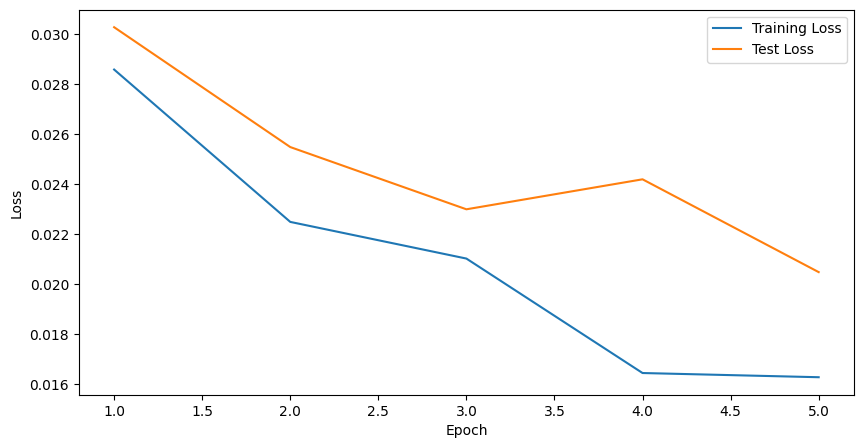

In [20]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Saliency Map

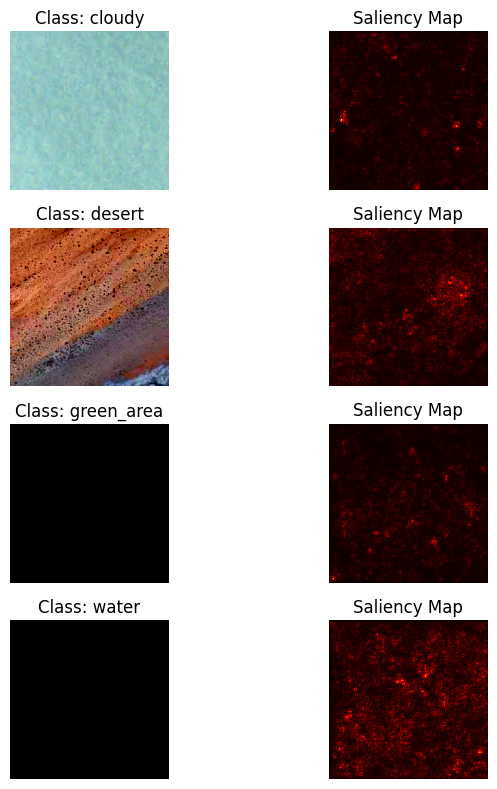

In [21]:
# Get some sample images from the test dataset
sample_images = []
sample_labels = []

# Collect at most one image per class
for class_index in range(len(dataset.classes)):
    class_images = torch.stack([image for image, label in test_dataset if label == class_index])
    if len(class_images) > 0:
        sample_images.append(class_images[0])
        sample_labels.append(class_index)

sample_images = torch.stack(sample_images)
sample_labels = torch.tensor(sample_labels)

# Generate and visualize saliency maps for each class
class_names = dataset.classes
num_classes = len(class_names)
fig, axes = plt.subplots(num_classes, 2, figsize=(8, 2 * num_classes))
for i in range(num_classes):
    class_index = i
    sample_image = sample_images[sample_labels == class_index][0]
    saliency_map = generate_saliency_map(sample_image, model)
    
    axes[i, 0].imshow(sample_image.permute(1, 2, 0).cpu().numpy())
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Class: {class_names[class_index]}')

    axes[i, 1].imshow(saliency_map.cpu().numpy(), cmap='hot')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Saliency Map')

plt.tight_layout()
plt.show()

# ***Comparision between the performance of the finetuned and original network***

In [22]:
print("Accuracy Comparison")
print(f"finetuned: {accuracy_1} | original network: {accuracy_2}")
print()

print("Recall Comparison")
print(f"finetuned: {recall_1} | original network: {recall_2}")
print()

print("Precision Comparison")
print(f"finetuned: {precision_1} | original network: {precision_2}")
print()

print("f1-score Comparison")
print(f"finetuned: {f1_1} | original network: {f1_2}")
print()

print("Confusion Matrix Comparison")
print("finetuned")
print(confusion_1)
print()
print("original network")
print(confusion_2)

Accuracy Comparison
finetuned: 0.997338065661047 | original network: 0.9964507542147294

Recall Comparison
finetuned: 0.997338065661047 | original network: 0.9964507542147294

Precision Comparison
finetuned: 0.9973410522003088 | original network: 0.9964742007824068

f1-score Comparison
finetuned: 0.9973381019063439 | original network: 0.9964520511051106

Confusion Matrix Comparison
finetuned
[[283   0   0   0]
 [  0 238   0   0]
 [  0   0 304   2]
 [  0   0   1 299]]

original network
[[281   0   1   1]
 [  0 238   0   0]
 [  0   0 304   2]
 [  0   0   0 300]]


# ***Explaination***

- ### ***Fine-tuning Adaptation***: Fine-tuning allows the model to adapt its pretrained weights to better fit the characteristics of the new dataset.

- ### ***Improved Class Detection***: The finetuned network shows higher recall, indicating its better ability to accurately detect instances of each class in the dataset.

- ### ***Similar Precision***: Both models have comparable precision, meaning they have a similar ability to avoid false positive predictions.

- ### ***Balanced Performance***: The F1-score, a balance between precision and recall, is marginally higher for the finetuned network, showing its slightly better overall performance.

- ### ***Reduced Misclassifications***: The confusion matrix reveals fewer misclassifications in the finetuned network, contributing to its higher accuracy and recall.